# Example of SPNA in two steps with the PTA Fourier Likelihood

## psr: J1738+0333

Paper reference: *add link* [ Fig. 1 ]

In this notebook, we show the application of the Fourier likelihood in a single pulsar noise analysis (SPNA). The analysis is divided in 2 steps:
- step 1: focus on the signals not covariant with a GWB (white noise, deterministic signals, etc.). The hyperparameters of the other signals are kept fixed in this step.
- step 2: focus on the signals covariant with a GWB (red noise (RN), DM variations, etc.). The signals ivestigated in the previous step get marginalized over.

Here, we present the case of pulsar J1738+0333 from EPTA DR2new. This is the same example shown in Fig. 1 of our paper. The noise model includes white noise (efac and equad specific for each observing backend), RN and DM variations (both modeled as Gaussian processes over, respectively, 30 and 100 frequency bins and a falt-tail powerlaw spectru)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sys, json
import dill as pickle
import scipy.linalg as sl

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals.selections import no_selection, Selection
from enterprise.signals import parameter, white_signals, utils, gp_signals, signal_base
from enterprise.signals.parameter import function
import enterprise.constants as const

import la_forge.gp as lfgp
import corner

In [9]:
##########################  FUNCTIONS ###########################################

# flat-tail powerlaw function for RN and DM var spectrum
#--------------------------------------------------------------------------------
from enterprise.signals.parameter import function
@function
def powerlaw_flat_tail(f, log10_A=-16, gamma=5, log10_kappa=-7, components=2):
    df = np.diff(np.concatenate((np.array([0]), f[::components])))
    pl = (10**log10_A) ** 2 / 12.0 / np.pi**2 * const.fyr ** (gamma - 3) * f ** (-gamma) * np.repeat(df, components)
    flat = 10 ** (2*log10_kappa)
    return np.maximum(pl, flat)


# build PTA object
#--------------------------------------------------------------------------------
def build_pta(psrs, fix_rn=True, fix_dm=True, fix_wn=True, logA_red=-15, gamma_red=4, logA_dm=-16, gamma_dm=3, log_kappa=-6, inc_dm=True):

    # find the maximum time span to set GW frequency sampling
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)

    # timing model
    tm = gp_signals.MarginalizingTimingModel(use_svd=True)

    # white noise
    if fix_wn == True:
        efac = parameter.Constant()
        equad = parameter.Constant()
    else:
        efac = parameter.Uniform(0.1,5)
        equad = parameter.Uniform(-10,-5)
    ef = white_signals.MeasurementNoise(efac=efac, selection=Selection(selections.by_backend))
    eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=Selection(selections.by_backend))

    # red noise
    if fix_rn == True:
        rn_log10_A = parameter.Constant(logA_red)
        rn_gamma = parameter.Constant(gamma_red)
        rn_log10_kappa = parameter.Constant(log_kappa)
    else:
        rn_log10_A = parameter.Uniform(-18, -12)
        rn_log10_kappa = parameter.Uniform(-9,-4)
        rn_gamma = parameter.Uniform(0,7)
    rn_pl = powerlaw_flat_tail(log10_A=rn_log10_A, gamma=rn_gamma, log10_kappa=rn_log10_kappa)
    rn = gp_signals.FourierBasisGP(spectrum=rn_pl, components=30, Tspan=Tspan)

    # DM variations
    if fix_dm == True:
        dm_log10_A = parameter.Constant(logA_dm)
        dm_gamma = parameter.Constant(gamma_dm) 
        dm_log10_kappa = parameter.Constant(log_kappa)
    else:
        dm_log10_A = parameter.Uniform(-18, -12)
        dm_gamma = parameter.Uniform(0,7)
        dm_log10_kappa = parameter.Uniform(-9,-4)
    pl_dm = powerlaw_flat_tail(log10_A=dm_log10_A, gamma=dm_gamma, log10_kappa=dm_log10_kappa)
    dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100)
    dm = gp_signals.BasisGP(priorFunction=pl_dm, basisFunction=dm_basis, name='dm')

    # final model
    model = tm + ef + eq + rn 
    
    if inc_dm == True:
        model = model + dm

    return signal_base.PTA([model(psr) for psr in psrs])

# reconstruct coeffs functions
#--------------------------------------------------------------------------------
def get_b(d, TNT, phiinv):
    Sigma_inv = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
    try:
        L = sl.cholesky(Sigma_inv, lower=True)
        mn = sl.cho_solve((L, True), d)
        test = 100
        coeffs = mn[:,None] + sl.solve_triangular(L, np.random.randn(L.shape[0],test), trans='T', lower=True)

    except np.linalg.LinAlgError:
        Q, R = sl.qr(Sigma_inv)
        Sigi = sl.solve(R, Q.T)
        mn = np.dot(Sigi, d)
        u, s, _ = sl.svd(Sigi)
        Li = u * np.sqrt(1/s)
        coeffs = mn[:,None] + np.dot(Li, np.random.randn(Li.shape[0],test))

    return coeffs.T


def reconstruct_coeffs(self, mlv=False, idx=None):

    if idx is None:
        idx = np.random.randint(self.burn, self.chain.shape[0])
    elif mlv:
        idx = self.mlv_idx

    # get parameter dictionary
    params = self.sample_posterior(idx)
    self.idx = idx
    coeffs = []

    TNrs, TNTs, phiinvs, Ts = self._get_matrices(params=params)

    for (p_ct, psrname, d, TNT, phiinv, T) in zip(self.p_idx, self.p_list,
                                                    TNrs, TNTs, phiinvs, Ts):
        coeffs.append(get_b(d, TNT, phiinv))

    return coeffs

# covariance matrix update function
#--------------------------------------------------------------------------------
def update_cov(Cs,ms,ns):
    n_mat = len(ns)
    C = 0
    m = 0
    for i in range(n_mat):
        C += (ns[i])*Cs[i] + ns[i]*ms[i].T*ms[i] 
        m += ns[i]*ms[i]
    m = m/np.sum(ns)
    m.shape
    C = C - np.sum(ns)*m.T*m
    C = C/(np.sum(ns))
    return C


In [29]:
# FOURIER LIKELIHOOD FUNCTION

def log_likelihood_Fourier(xs):

    '''
        New Fourier likelihood for PTA analysis
        (simplified version for SPNA with RN and DM var only)
    '''
    params = xs if isinstance(xs, dict) else pta.map_params(xs)
    loglike = 0
    
    phiinv, logdet_phi = pta.get_phiinv(params, logdet=True)[0]
    
    Sigma_inv = Sigma_0_inv - np.diag(phiinv_0) + np.diag(phiinv)
    Li, lower = sl.cho_factor(Sigma_inv, lower=True)
    Sigma = sl.cho_solve((Li,True), np.identity(len(Li)))
    expval = sl.cho_solve((Li,True), Si0_a_hat)

    loglike += -0.5 * np.sum(pta.get_rNr_logdet(params))   
    loglike += sum(pta.get_logsignalprior(params))
    logdet_sigma = np.sum(2 * np.log(np.diag(Li)))
    loglike += 0.5 * (np.dot(Si0_a_hat, expval) - logdet_sigma - logdet_phi)
    
    return loglike

In [ ]:
##########################  MAIN CODE ###########################################

In [ ]:
name = 'J1738+0333'
# directories
home_dir = '...'
data_dir = home_dir + '...'

# pulsar object
psr = Pulsar(data_dir+name+'.par',data_dir+name+'_all.tim')

# EPTA max Likelihood values (DR2new) for WN
noise_ML_dir = data_dir + name + '_Wnoise.json'
with open(noise_ML_dir, 'r') as f:
    noise_ML = json.load(f)
    f.close()

### Step 1:

The first step has been carried out outside this notebook. Use the function *build_pta* to construct a PTA object where the hyperparameters of RN and Dm variations are fixed (in this example: logA = -12, gamma = 5, log_kappa = -5 for both RN and DM).

In [6]:
pta_0 = build_pta([psr], fix_wn=False, logA_red=-12, gamma_red=5, logA_dm=-12, gamma_dm=5, log_kappa=-5)
pta_0.param_names

['J1738+0333_EFF.P200.1380_efac',
 'J1738+0333_EFF.P200.1380_log10_tnequad',
 'J1738+0333_EFF.P217.1380_efac',
 'J1738+0333_EFF.P217.1380_log10_tnequad',
 'J1738+0333_JBO.ROACH.1520_efac',
 'J1738+0333_JBO.ROACH.1520_log10_tnequad',
 'J1738+0333_NRT.NUPPI.1484_efac',
 'J1738+0333_NRT.NUPPI.1484_log10_tnequad',
 'J1738+0333_WSRT.P2.1380_efac',
 'J1738+0333_WSRT.P2.1380_log10_tnequad']

Using the oblect *pta_0*, sample with PTMCMCSampler over the free parameters. The resulting chain is located at *step1_chain_dir* directory.

In [8]:
# reading the step1 chain 
step1_chain_dir = data_dir + '...'
step1_chain = np.loadtxt(step1_chain_dir)
burn = int(0.25 * step1_chain.shape[0]) 
chain_no_burn = step1_chain[burn:,:]
print('WN chain read')

WN chain read


In [13]:
# computing the Sigma_0 and a_hat_0 quantities that we will need to write the Fourier likelihood

# phiinv_0
phiinv_0, logdet_phiinv_0 = pta_0.get_phiinv([],logdet=True)[0]

# Sigma_0_inv and a_hat
N = 10000
ns = np.ones(N)
lfrec = lfgp.Signal_Reconstruction([psr], pta_0, chain_no_burn, burn=0)
lfrec.reconstruct_coeffs = reconstruct_coeffs
Sigma_0_inv_list = []
a_hat_list = []

for i in range(N):
    
    idx = np.random.choice(np.arange(len(chain_no_burn)), size=1, replace=False)
    params = lfrec.sample_posterior(idx)
    TNT = pta_0.get_TNT(params)[0]
    TNr = pta_0.get_TNr(params)[0]
    
    Sigma_0_inv_step = TNT + np.diag(phiinv_0)
    Li, lower = sl.cho_factor(Sigma_0_inv_step, lower=True)
    a_hat_step = sl.cho_solve((Li, True), TNr)

    Sigma_0_inv_list.append(Sigma_0_inv_step)
    a_hat_list.append(a_hat_step)

Sigma_0_inv_list = np.array(Sigma_0_inv_list)
a_hat_list = np.array(a_hat_list)

Sigma_0_inv = update_cov(Sigma_0_inv_list,a_hat_list,ns)
a_hat = np.mean(a_hat_list,axis=0)

Li, lower = sl.cho_factor(Sigma_0_inv, lower=True)
logdet_sigma_0 = np.sum(2 * np.log(np.diag(Li)))

# sigma 0 * a hat
Si0_a_hat = np.dot(Sigma_0_inv, a_hat)

print('the 0 quantities are computed')

the 0 quantities are computed


### Step 2:

We sample over RN and DM hyperparameters with the Fourier likelihood:

$$\begin{aligned}
    {\rm ln} \Bigl( p(\rho, \theta |\{\delta t\}) \Bigr) & = \int {\rm d}^{N_p}a \, {\rm ln} \Bigl[p(\{ a\},\rho_0, \theta | \{\delta t\}) \times 
    \frac{p( \{a\}|\rho)p(\rho)}{p( \{a\}|\rho_0)p(\rho_0)} \Bigr] \\
    &  = \frac{1}{2} \hat{a}_0^T \Sigma_0^{-1} \Sigma \Sigma_0^{-1}\hat{a}_0 - \frac{1}{2} 
    \delta t^T \tilde{N}^{-1} \delta t - \frac{1}{2} \bigl[
    {\rm lndet}(2\pi N) + {\rm lndet}(2\pi M^TN^{-1}M) + {\rm lndet}(2\pi\phi) -
     {\rm lndet}(2\pi \Sigma) \bigr] \, ,
    \end{aligned}$$

which is Eq. (19) of our paper.

In [15]:
# pta object for the sampling over RN+DM with the new likelihood
# NB: it is important to use the likelihood function that this object is called pta 
# (because of how the Fourier likelihood function is defined)!!!!
pta = build_pta([psr], fix_rn=False, fix_dm=False)
pta.set_default_params(noise_ML)
print(pta.param_names)

INFO: enterprise.signals.signal_base: Setting J1738+0333_EFF.P200.1380_efac to 1.2329115324118975
INFO: enterprise.signals.signal_base: Setting J1738+0333_EFF.P217.1380_efac to 0.8867280280191301
INFO: enterprise.signals.signal_base: Setting J1738+0333_JBO.ROACH.1520_efac to 0.7472756385097318
INFO: enterprise.signals.signal_base: Setting J1738+0333_NRT.NUPPI.1484_efac to 0.8613738492525165
INFO: enterprise.signals.signal_base: Setting J1738+0333_WSRT.P2.1380_efac to 1.1112003518112685
INFO: enterprise.signals.signal_base: Setting J1738+0333_EFF.P200.1380_log10_tnequad to -6.79109245509378
INFO: enterprise.signals.signal_base: Setting J1738+0333_EFF.P217.1380_log10_tnequad to -7.93640722539657
INFO: enterprise.signals.signal_base: Setting J1738+0333_JBO.ROACH.1520_log10_tnequad to -5.43250967829
INFO: enterprise.signals.signal_base: Setting J1738+0333_NRT.NUPPI.1484_log10_tnequad to -7.826039383135421
INFO: enterprise.signals.signal_base: Setting J1738+0333_WSRT.P2.1380_log10_tnequad t

['J1738+0333_dm_gamma', 'J1738+0333_dm_log10_A', 'J1738+0333_dm_log10_kappa', 'J1738+0333_red_noise_gamma', 'J1738+0333_red_noise_log10_A', 'J1738+0333_red_noise_log10_kappa']


Sampling....

In [30]:
# sampling
xs = {par.name: par.sample() for par in pta.params}
print('test ln_likelihood: ',log_likelihood_Fourier(xs),'\n')

ndim = len(xs)
cov = np.diag(np.ones(ndim) * 0.01**2)
groups = None
Num = 1e6
outdir = data_dir + '...'
sampler = ptmcmc(ndim, log_likelihood_Fourier, pta.get_lnprior, cov, groups=groups, outDir=outdir, resume=False)
x0 = np.hstack([p.sample() for p in pta.params])

test ln_likelihood:  7251.61716187388 



In [ ]:
print('start sampling')
sampler.sample(x0, Num, burn=10000)

### posterior plots and comparison with a full SPNA 

The posteriors obtained with this method (orange) are obtained marginalising over the WN parameters. Therefore, they are equivalent to posteriors (blue) obtained with the standard time-domain likelihood (*pta.get_lnlikelihood()*) in the case of a SPNA over *all* the noise parameters (WN+RN+DM).

In [31]:
# Fourier chain
chain = np.loadtxt(outdir+'/chain_1.txt')
burn = int(0.25 * chain.shape[0])

# spna chain (time-domain likelihood)
# (obtained from an independent analysis)
spna_chain_dir = data_dir + '...'
spna_chain = np.loadtxt(spna_chain_dir)
burn_spna = int(0.25 * spna_chain.shape[0]) 

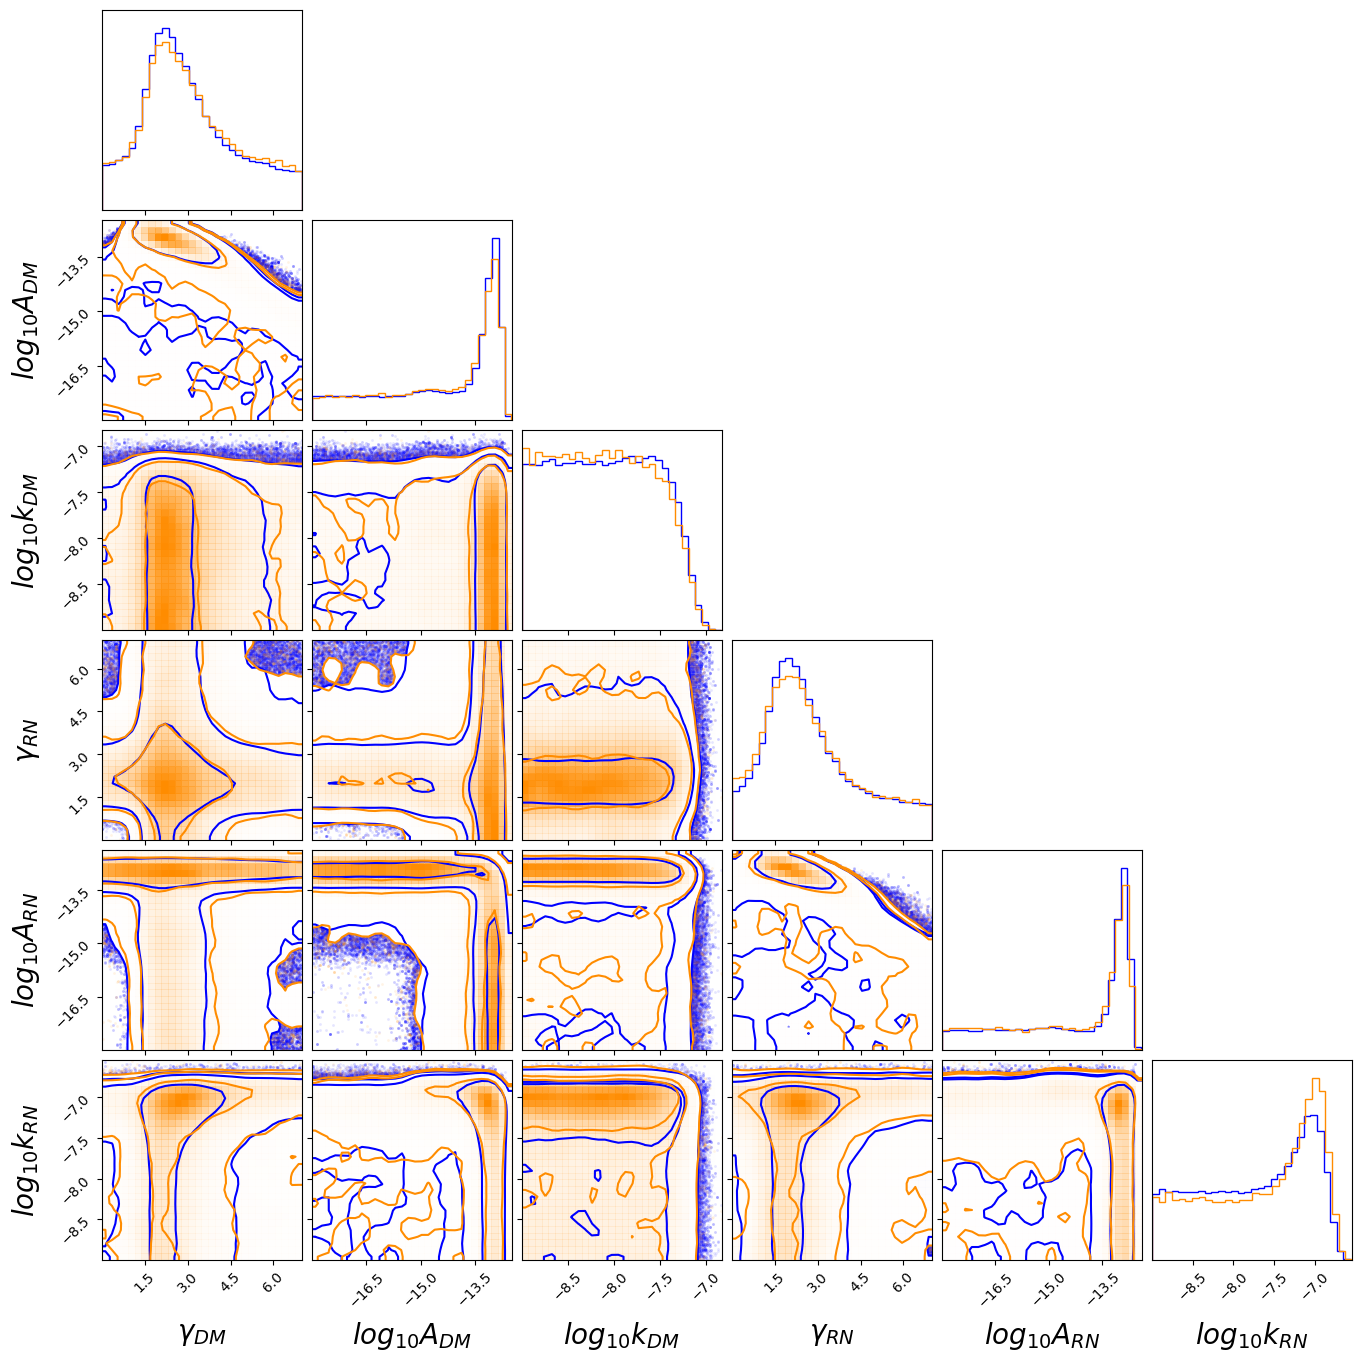

In [32]:
# to show the 1, 2 and 3 sigma contours 
exp_lev = np.array([1, 2, 3])
mp_array = 1 - np.exp(-0.5*exp_lev**2)

# normalisation weights for representation
wo = np.ones(len(spna_chain[burn_spna:,0]))/len(spna_chain[burn_spna:,0])
w = np.ones(len(chain[burn:,0]))/len(chain[burn:,0])

pars = ['$\gamma_{DM}$', '$log_{10}A_{DM}$', '$log_{10}k_{DM}$','$\gamma_{RN}$', '$log_{10}A_{RN}$', '$log_{10}k_{RN}$' ]
title_font_size = 20

fig = corner.corner(spna_chain[burn_spna:,-10:-4], 30, weights=wo,levels=mp_array, color='blue', smooth=True, labels=pars, label_kwargs={"fontsize": title_font_size});
fig1 = corner.corner(chain[burn:,:-4], 30, weights=w, levels=mp_array, color='darkorange', smooth=True, fig=fig, label_kwargs={"fontsize": title_font_size});

plt.show()